In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
from train import HomographyModel
import matplotlib.pyplot as plt
import cv2
import torch



2023-12-29 23:01:28.858554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-29 23:01:28.858597: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-29 23:01:28.858620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-29 23:01:28.863683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-29 23:01:30.439628: I tensorflow/compiler/

Default GPU Device: /device:GPU:0


## utils

In [2]:

def to_torch(np_array):
    """Parse a numpy array to a torch variable

    Arguments:
        np_array: a np.array 
    Returns:
        a torch Var with the same value as the np_array
    Raises:
        
    """
    tensor = torch.from_numpy(np_array).float()
    return torch.autograd.Variable(tensor, requires_grad=False)

def np_img_to_torch_img(np_img):
    """Convert a np image to a torch image

    Arguments:
        np_img: a np.array of shape (B,H,W,C) or (H,W,C)
    Returns:
        a Tensor of shape (B,C,H,W) or (C,H,W)
    Raises:
        ValueError: If this is not a np.array
    """
    if isinstance(np_img, torch.Tensor):
        return np_img
    assert isinstance(np_img, np.ndarray), "cannot process data type: {0}".format(
        type(np_img)
    )
    if len(np_img.shape) == 4 and (np_img.shape[3] == 3 or np_img.shape[3] == 1):
        return to_torch(np.transpose(np_img, (0, 3, 1, 2)))
    if len(np_img.shape) == 3 and (np_img.shape[2] == 3 or np_img.shape[2] == 1):
        return to_torch(np.transpose(np_img, (2, 0, 1)))
    elif len(np_img.shape) == 2:
        return to_torch(np_img)
    else:
        raise ValueError("cannot process this image")


def warp_image_torch(img, H, out_shape=None):
    """Apply an homography to a torch Tensor

    Arguments:
        img: Tensor of shape (B,C,H,W) or (C,H,W)
        H: Tensor of shape (B,3,3) or (3,3), the homography
        out_shape: Tuple, the wanted shape of the out image
    Returns:
        A Tensor of shape (B) x (out_shape) or (B) x (img.shape), the warped image 
    Raises:
        ValueError: If img and H batch sizes are different
    """
    if out_shape is None:
        out_shape = img.shape[-2:]
    if len(img.shape) < 4:
        img = img[None]
    if len(H.shape) < 3:
        H = H[None]
    if img.shape[0] != H.shape[0]:
        raise ValueError(
            "batch size of images ({}) do not match the batch size of homographies ({})".format(
                img.shape[0], H.shape[0]
            )
        )
    batchsize = img.shape[0]
    # create grid for interpolation (in frame coordinates)

    y, x = torch.meshgrid(
        [
            torch.linspace(-0.5, 0.5, steps=out_shape[-2]),
            torch.linspace(-0.5, 0.5, steps=out_shape[-1]),
        ]
    )
    x = x.to(img.device)
    y = y.to(img.device)
    x, y = x.flatten(), y.flatten()

    # append ones for homogeneous coordinates
    xy = torch.stack([x, y, torch.ones_like(x)])
    xy = xy.repeat([batchsize, 1, 1])  # shape: (B, 3, N)
    # warp points to model coordinates
    xy_warped = torch.matmul(H, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)

    # we multiply by 2, since our homographies map to
    # coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
    xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
    x_warped, y_warped = torch.unbind(xy_warped, dim=1)
    # build grid
    grid = torch.stack(
        [
            x_warped.view(batchsize, *out_shape[-2:]),
            y_warped.view(batchsize, *out_shape[-2:]),
        ],
        dim=-1,
    )

    # sample warped image
    warped_img = torch.nn.functional.grid_sample(
        img, grid, mode="bilinear", padding_mode="zeros"
    )
    return warped_img


def torch_img_to_np_img(torch_img):
    """Convert a torch image to a numpy image

    Arguments:
        torch_img: Tensor of shape (B,C,H,W) or (C,H,W)
    Returns:
        a np.array of shape (B,H,W,C) or (H,W,C)
    Raises:
        ValueError: If this is not a Torch tensor
    """
    if isinstance(torch_img, np.ndarray):
        return torch_img
    assert isinstance(torch_img, torch.Tensor), "cannot process data type: {0}".format(
        type(torch_img)
    )
    if len(torch_img.shape) == 4 and (
        torch_img.shape[1] == 3 or torch_img.shape[1] == 1
    ):
        return np.transpose(torch_img.detach().cpu().numpy(), (0, 2, 3, 1))
    if len(torch_img.shape) == 3 and (
        torch_img.shape[0] == 3 or torch_img.shape[0] == 1
    ):
        return np.transpose(torch_img.detach().cpu().numpy(), (1, 2, 0))
    elif len(torch_img.shape) == 2:
        return torch_img.detach().cpu().numpy()
    else:
        raise ValueError("cannot process this image")
    

def visualize(**images):
    """PLot images in one row.

    Arguments:
        **images: images to plot
    Returns:
        
    Raises:
        
    """
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image)
    plt.show

In [3]:
import torch

from kornia.geometry.transform.imgwarp import get_perspective_transform
def get_corners_from_nn(batch_corners_pred):
    """Gets the corners in the right shape, from a DeepHomoModel

    Arguments:
        batch_corners_pred: np.array of shape (B,8) with the predictions
    Returns:
        corners: np.array of shape (B,4,2) with the corners in the right shape
    Raises:
        
    """
    batch_size = batch_corners_pred.shape[0]
    corners = np.reshape(batch_corners_pred, (-1, 2, 4))
    corners = np.transpose(corners, axes=(0, 2, 1))
    corners = np.reshape(corners, (batch_size, 4, 2))
    return corners

def get_default_corners(batch_size):
    """Get coordinates of the default corners in a soccer field

    Arguments:
        batch_size: Integer, the number of time we need the corners
    Returns:
        orig_corners: a np.array of len(batch_size)
    Raises:
        
    """
    orig_corners = np.array(
        [[-0.5, 0.1], [-0.5, 0.5], [0.5, 0.5], [0.5, 0.1]], dtype=np.float32
    )
    orig_corners = np.tile(orig_corners, (batch_size, 1, 1))
    return orig_corners

def get_perspective_transform_torch(src, dst):
    """Get the homography matrix between src and dst

    Arguments:
        src: Tensor of shape (B,4,2), the four original points per image
        dst: Tensor of shape (B,4,2), the four corresponding points per image
    Returns:
        A tensor of shape (B,3,3), each homography per image
    Raises:

    """
    return cv2.getPerspectiveTransform(src, dst)

def compute_homography(batch_corners_pred):
    """Compute the homography from the predictions of DeepHomoModel

    Arguments:
        batch_corners_pred: np.array of shape (B,8) with the predictions
    Returns:
        np.array of shape (B,3,3) with the homographies
    Raises:
        
    """
    batch_size = batch_corners_pred.shape[0]
    corners = get_corners_from_nn(batch_corners_pred)
    print(corners)
    orig_corners = get_default_corners(batch_size)
    print(orig_corners)
    return corners, orig_corners
    # homography = get_perspective_transform_torch(
    #     to_torch(orig_corners), to_torch(corners)
    # )
    # return to_numpy(homography)
def to_numpy(var):
    """Parse a Torch variable to a numpy array

    Arguments:
        var: torch variable
    Returns:
        a np.array with the same value as var
    Raises:
        
    """
    try:
        return var.numpy()
    except:
        return var.detach().numpy()


def to_torch(np_array):
    """Parse a numpy array to a torch variable

    Arguments:
        np_array: a np.array 
    Returns:
        a torch Var with the same value as the np_array
    Raises:
        
    """
    tensor = torch.from_numpy(np_array).float()
    return torch.autograd.Variable(tensor, requires_grad=False)
def get_four_corners(homo_mat):
    """Inverse operation of compute_homography. Gets the 4 corners from an homography.

    Arguments:
        homo_mat: Matrix of shape (B,3,3) or (3,3), homographies
    Returns:
        xy_warped: np.array of shape (B,4,2) with the corners
    Raises:
        ValueError: If the homographies are not of shape (3,3)
    """
    if isinstance(homo_mat, np.ndarray):
        homo_mat = to_torch(homo_mat)

    if homo_mat.shape == (3, 3):
        homo_mat = homo_mat[None]
    if homo_mat.shape[1:] != (3, 3):
        raise ValueError(
            "The shape of the homography is {}, not (3,3)".format(homo_mat.shape[1:])
        )

    canon4pts = to_torch(
        np.array([[-0.5, 0.1], [-0.5, 0.5], [0.5, 0.5], [0.5, 0.1]], dtype=np.float32)
    )

    assert canon4pts.shape == (4, 2)
    x, y = canon4pts[:, 0], canon4pts[:, 1]
    xy = torch.stack([x, y, torch.ones_like(x)])
    # warp points to model coordinates
    xy_warped = torch.matmul(homo_mat, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)
    xy_warped = xy_warped / (z_warped + 1e-8)
    xy_warped = to_numpy(xy_warped)
    return xy_warped

# get_four_corners(H)

## MODEL TEST

In [5]:
model = HomographyModel(input_shape=(320, 320, 3))

model.load_model("./homography_checkpoints/best_ckpt.hdf5")

2023-12-29 21:33:41.755800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 21:33:41.755994: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 21:33:41.756105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

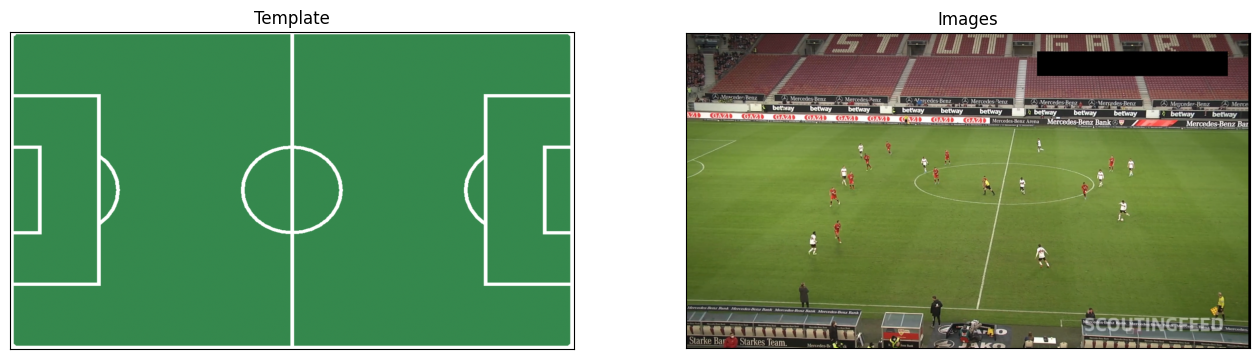

In [29]:
img = cv2.cvtColor(cv2.imread('../../images/frame.png'), cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (320,320))
template = cv2.cvtColor(cv2.imread('./template_2.png'), cv2.COLOR_BGR2RGB)
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.
visualize(template=template, images=img)

In [30]:
res = model('../../images/frame.png')
res = res.astype(np.float64)

1/1 [==============================] - 0s 37ms/step


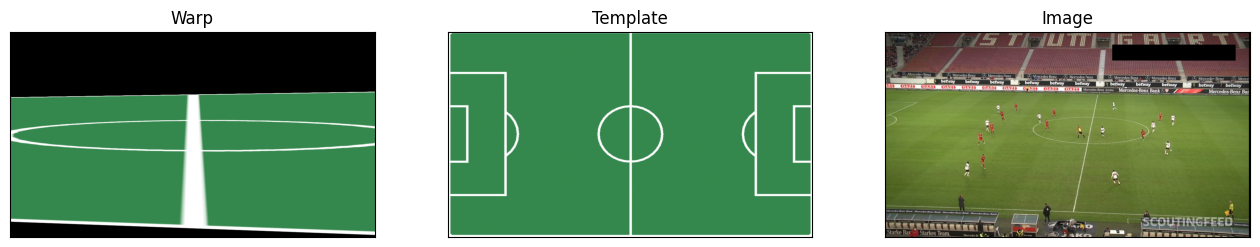

In [31]:
warp = warp_image_torch(np_img_to_torch_img(template), to_torch(res))
warp = torch_img_to_np_img(warp[0])
visualize(
        warp=warp,
        template=template,
        image=img,
    )

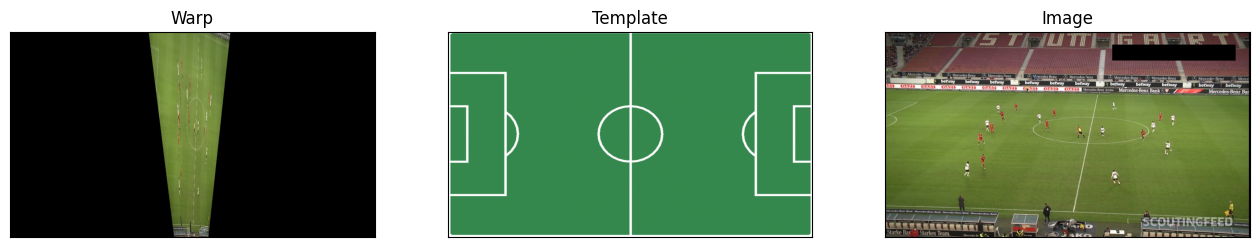

In [32]:
warp = warp_image_torch(np_img_to_torch_img(cv2.resize(img, (1280,720))/255.), to_torch(torch.inverse(to_torch(res)).numpy()))
warp = torch_img_to_np_img(warp[0])
visualize(
        warp=warp,
        template=template,
        image=img,
    )

## IMAGES FROM TRAIN

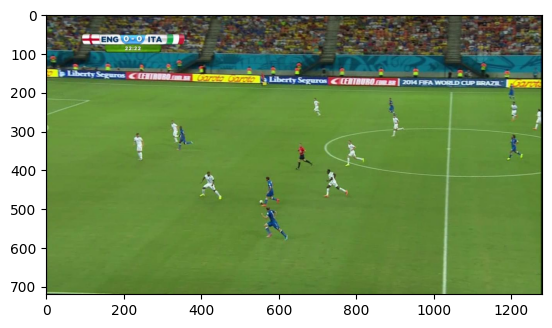

In [10]:
img_path = "/home/fer/Escritorio/futstatistics/datasets/narya/homography_dataset/dataset/train_img/0.jpg"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (320,320))
plt.imshow(img)

In [4]:
H = np.load("/home/fer/Escritorio/futstatistics/datasets/narya/homography_dataset/dataset/train_homo/0_homo.npy")
H

array([[ 3.32257970e-01,  5.57784683e-04, -1.05540221e-01],
       [-9.27922205e-02,  1.55204300e+00,  4.58290388e-02],
       [-3.38531888e-02,  1.59596583e+00,  1.00000000e+00]])

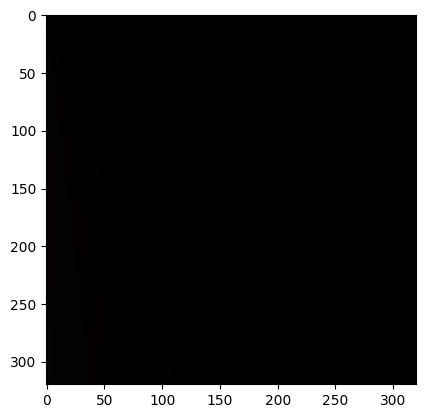

In [12]:
warped = cv2.warpPerspective(img, H, dsize=(320,320))
plt.imshow(warped)

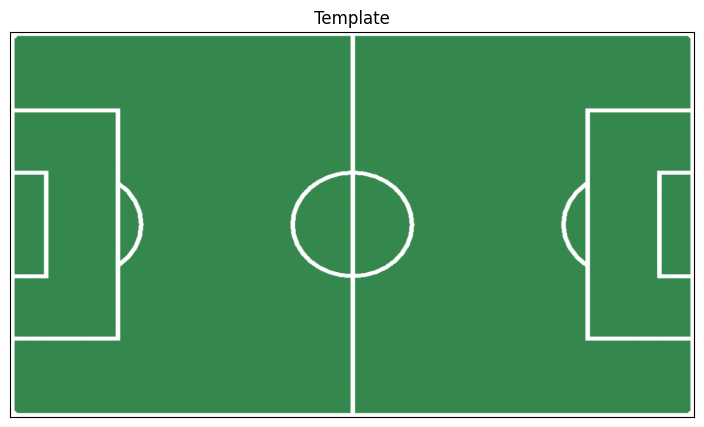

In [13]:
template = cv2.cvtColor(cv2.imread('./template_2.png'), cv2.COLOR_BGR2RGB)
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))/255.
visualize(template=template)

In [14]:
warp = warp_image_torch(np_img_to_torch_img(template), to_torch(H))
warp = torch_img_to_np_img(warp[0])

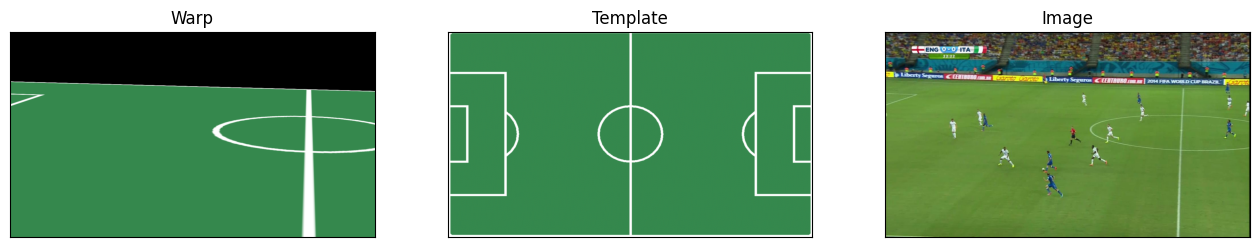

In [15]:
visualize(
        warp=warp,
        template=template,
        image=img,
    )

In [16]:
H_ = torch.inverse(to_torch(H)).numpy()
H_

array([[ 2.9488845 , -0.33697367,  0.32666913],
       [ 0.18193129,  0.65538806, -0.01083473],
       [-0.190527  , -1.0573846 ,  1.0283507 ]], dtype=float32)

In [17]:
warp = warp_image_torch(np_img_to_torch_img(img), to_torch(H_))
warp = torch_img_to_np_img(warp[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


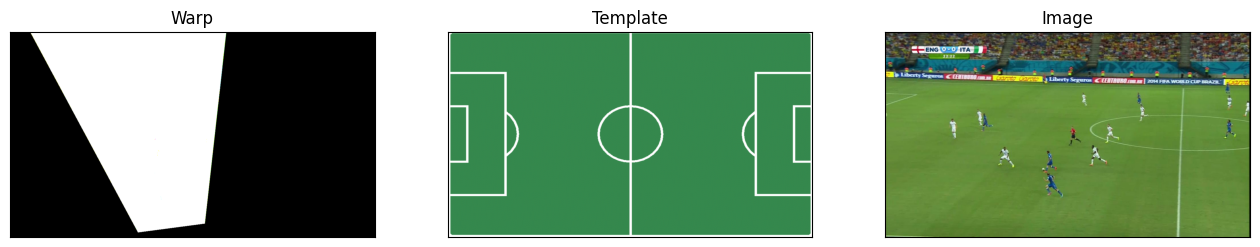

In [18]:
visualize(
        warp=warp,
        template=template,
        image=img,
    )

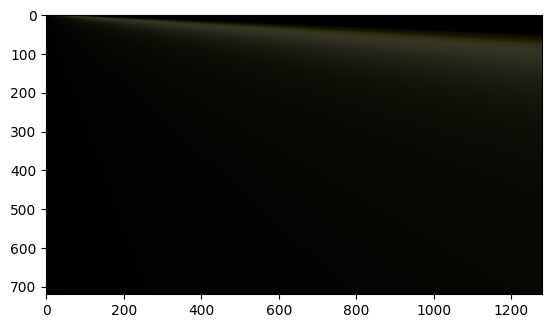

In [19]:
plt.imshow(cv2.warpPerspective(img, H_, (template.shape[1], template.shape[0]), flags=cv2.INTER_LINEAR))


## MANUAL H 

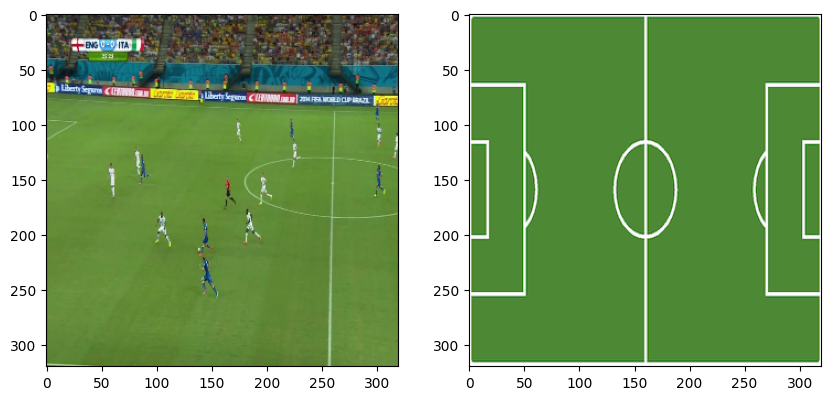

In [20]:
img_path = "/home/fer/Escritorio/futstatistics/datasets/narya/homography_dataset/dataset/train_img/0.jpg"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (320,320))


template = cv2.cvtColor(cv2.imread('./template.png'), cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (320,320))


fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(img)
ax[1].imshow(template)

In [21]:
points1 = [
    (260, 185),
    (30, 100),
    (260,90),
    (260,125),
    (0,320)
]

In [22]:
points2 = [
    (160, 200),
    (50, 60),
    (160,5),
    (160,110),
    (100,320)
]

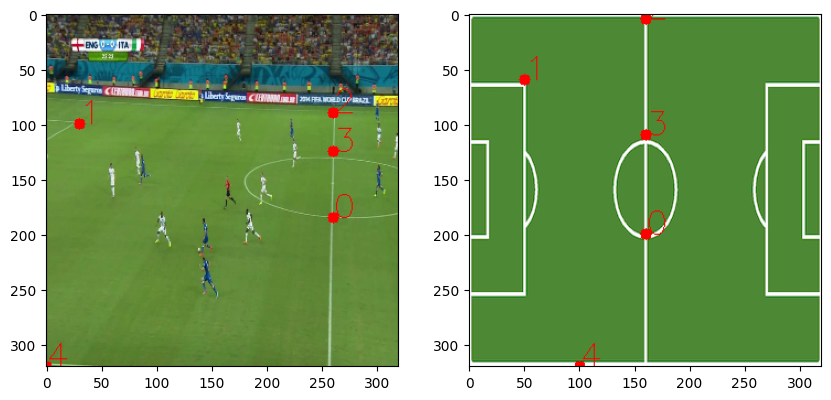

In [23]:
image_ann = img.copy()
template_ann = template.copy()

for i,(p1,p2) in enumerate(zip(points1,points2)):
    image_ann = cv2.circle(image_ann, p1, 5, (255, 0, 0), -1)
    image_ann = cv2.putText(image_ann, str(i), p1, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),1)

    template_ann = cv2.circle(template_ann, p2, 5, (255, 0, 0), -1)
    template_ann = cv2.putText(template_ann, str(i), p2, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0),1)


fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(image_ann)
ax[1].imshow(template_ann)

In [24]:
# given the two lists of points calculate the homography
H2 = cv2.findHomography(np.array(points1), np.array(points2))[0]
H2

array([[ 1.53399165e+00,  3.08935984e+00, -2.03945835e+02],
       [-2.69385099e-01,  1.02493979e+01, -8.30950993e+02],
       [ 1.45098179e-04,  2.08262735e-02,  1.00000000e+00]])

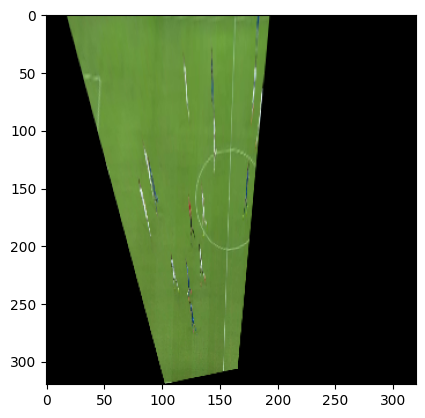

In [25]:
warped = cv2.warpPerspective(img, H2, dsize=(320,320))
plt.imshow(warped)

In [26]:
def warp_image_torch(img, H, out_shape=None):
    """Apply an homography to a torch Tensor

    Arguments:
        img: Tensor of shape (B,C,H,W) or (C,H,W)
        H: Tensor of shape (B,3,3) or (3,3), the homography
        out_shape: Tuple, the wanted shape of the out image
    Returns:
        A Tensor of shape (B) x (out_shape) or (B) x (img.shape), the warped image 
    Raises:
        ValueError: If img and H batch sizes are different
    """
    if out_shape is None:
        out_shape = img.shape[-2:]
    if len(img.shape) < 4:
        img = img[None]
    if len(H.shape) < 3:
        H = H[None]
    if img.shape[0] != H.shape[0]:
        raise ValueError(
            "batch size of images ({}) do not match the batch size of homographies ({})".format(
                img.shape[0], H.shape[0]
            )
        )
    batchsize = img.shape[0]
    # create grid for interpolation (in frame coordinates)

    y, x = torch.meshgrid(
        [
            torch.linspace(-0.5, 0.5, steps=out_shape[-2]),
            torch.linspace(-0.5, 0.5, steps=out_shape[-1]),
        ]
    )
    x = x.to(img.device)
    y = y.to(img.device)
    x, y = x.flatten(), y.flatten()

    # append ones for homogeneous coordinates
    xy = torch.stack([x, y, torch.ones_like(x)])
    xy = xy.repeat([batchsize, 1, 1])  # shape: (B, 3, N)
    # warp points to model coordinates
    xy_warped = torch.matmul(H, xy)  # H.bmm(xy)
    xy_warped, z_warped = xy_warped.split(2, dim=1)

    # we multiply by 2, since our homographies map to
    # coordinates in the range [-0.5, 0.5] (the ones in our GT datasets)
    xy_warped = 2.0 * xy_warped / (z_warped + 1e-8)
    x_warped, y_warped = torch.unbind(xy_warped, dim=1)
    # build grid
    grid = torch.stack(
        [
            x_warped.view(batchsize, *out_shape[-2:]),
            y_warped.view(batchsize, *out_shape[-2:]),
        ],
        dim=-1,
    )

    # sample warped image
    warped_img = torch.nn.functional.grid_sample(
        img, grid, mode="bilinear", padding_mode="zeros"
    )


    return warped_img

In [27]:
H/H2

array([[ 2.16596988e-01,  1.80550248e-04,  5.17491426e-04],
       [ 3.44459366e-01,  1.51427724e-01, -5.51525171e-05],
       [-2.33312293e+02,  7.66323281e+01,  1.00000000e+00]])

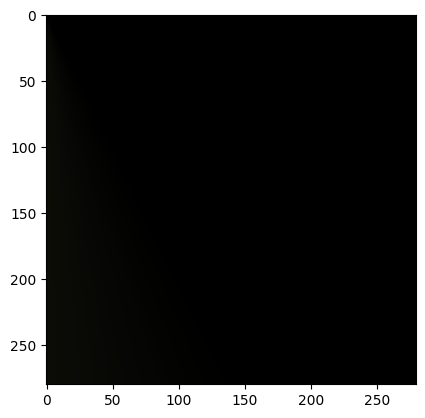

In [28]:
warped = cv2.warpPerspective(img, H, dsize=(280,280))
plt.imshow(warped)